***How to Do Experiment Tracking:***

1. Go to the VS Code Terminal.
2. Ensure the Conda environment is active.
3. Navigate to the root directory of the project (where the mlruns folder is located).
4. Type the command `mlflow ui` and hit Enter.
5. See a message saying "Serving on http://127.0.0.1:5000".
6. Ctrl + Click that link (or open a web browser and type http://localhost:5000).

# 3.1 Business Assumptions 

The datasets used in this project were obtained from a Sri Lankan Telco company. Hence, these general estimates were derived from **Dialog Axiata’s FY2024 Financial Statements** and **TRCSL (Telecommunications Regulatory Commission of Sri Lanka)** official reports.

## Data Sources & References:

  * **Revenue & Subscriber Base:**

      * **Source:** *Dialog Axiata PLC Annual Report 2024*.
      * **Data:** Revenue of **Rs. 171.17 Billion** and a total subscriber base of **19.1 Million**.
      * **Link:** [Dialog Axiata PLC Annual Report 2024 (Colombo Stock Exchange)](https://cdn.cse.lk/cmt/upload_report_file/389_1747616410421.pdf)

  * **Prepaid vs. Postpaid Split (92% Prepaid):**

      * **Source:** *Dialog Axiata Fact Sheet (2024)*.
      * **Data:** 17.5M Prepaid users vs. 1.5M Postpaid users.
      * **Link:** [Dialog Axiata Fact Sheet](https://www.dialog.lk/fact-sheet)

  * **SMS Pricing (Cost of Contact):**

      * **Source:** *Dialog Enterprise / Third-Party Bulk SMS Rates*.
      * **Data:** Standard commercial bulk SMS rates in Sri Lanka range from **LKR 0.50 to LKR 1.00** per SMS.
      * **Link:** [Sri Lanka SMS Pricing Benchmarks](https://www.sent.dm/resources/sri-lanka-sms-pricing)

  * **Industry Market Context:**

      * **Source:** *Telecommunications Regulatory Commission of Sri Lanka (TRCSL)*.
      * **Data:** Confirmation of mobile penetration rates and competitive operator landscape (Dialog, SLT-Mobitel, Hutch).
      * **Link:** [TRCSL Telecom Statistics 2024/25](https://www.trc.gov.lk/pages_e.php?id=12)


In [156]:
# --- SRI LANKA BUSINESS ASSUMPTIONS (2024/25 DATA) ---
# Sources: Dialog Axiata PLC Annual Report 2024 & TRCSL Statistics

# 1. ARPU (Average Revenue Per User)
# Source: Dialog Axiata FY2024 Revenue (Rs. 171.2Bn) / Subscribers (19.1Mn)
# Calculation: 171,171,000,000 / 19,097,715 / 12 months = Rs. 746.90
ARPU_LKR = 750.00 

# 2. Retention Period
# Logic: Prepaid churn in developing markets ranges from 3-6% monthly.
# "Saved" customers are higher risk, so we discount the standard lifetime 
# to a conservative 12-month period.
RETENTION_PERIOD_MONTHS = 12

# 3. Cost of Contact (SMS)
# Source: Local bulk SMS rates (Dialog/Mobitel Enterprise Rates)
# Rate: Approx Rs. 0.50 - 1.00 per SMS. 
# Campaign: 3 SMS sequence + Overhead = Rs. 3.00
COST_CONTACT_LKR = 3.00

# 4. Cost of Offer (The "Save" Incentive)
# Logic: We apply a "Gold Tier" retention offer (30% discount), aligning with
# Dialog's standard loyalty benefits for mid-value customers.
# Calculation: Rs. 750 (ARPU) * 30% = Rs. 225.
COST_OFFER_LKR = 225.00

# 5. Acceptance Rate
# Based on price elasticity in the Sri Lankan prepaid market, uptake drops slightly.
# We estimate a conservative 25% acceptance rate for this tier.
ACCEPTANCE_RATE = 0.25

# --- DERIVED METRICS ---
LTV_LKR = ARPU_LKR * RETENTION_PERIOD_MONTHS # ~Rs. 9,000
BREAKEVEN_PROB = (COST_OFFER_LKR + COST_CONTACT_LKR) / (LTV_LKR * ACCEPTANCE_RATE)

print(f"--- 🇱🇰 SRI LANKA MARKET CONTEXT ---")
print(f"Verified ARPU: Rs. {ARPU_LKR:,.2f} (Based on Dialog FY24 Reports)")
print(f"Estimated LTV: Rs. {LTV_LKR:,.2f}")
print(f"Campaign Cost: Rs. {COST_CONTACT_LKR:.2f} (3x SMS)")
print(f"Offer Cost:    Rs. {COST_OFFER_LKR:.2f} (30% Discount)")


--- 🇱🇰 SRI LANKA MARKET CONTEXT ---
Verified ARPU: Rs. 750.00 (Based on Dialog FY24 Reports)
Estimated LTV: Rs. 9,000.00
Campaign Cost: Rs. 3.00 (3x SMS)
Offer Cost:    Rs. 225.00 (30% Discount)


# 3.2 Library & Experiment Tracking Setup

In [2]:
# Essentiall Librairies
import pandas as pd
import numpy as np

In [3]:
# Hyperparameter Optimization
import optuna

In [4]:
# Initialize experiment tracking
%load_ext autoreload
%autoreload 2

import mlflow
import sys
import os

# Add project root to path (standard setup)
sys.path.append(os.path.abspath('..'))

# Initialize MLflow
# Notice we import from your specific package name now
from telco_customer_churn_prediction import configure_mlflow

configure_mlflow(name_experiment="Telco_Customer_Churn_Prediction_LKR")

2025-12-05 21:18:27.253 | INFO     | telco_customer_churn_prediction.config:<module>:12 - PROJ_ROOT path is: E:\Data_Science\Repositories\telco-customer-churn-prediction
e:\Data_Science\envs\telco-churn\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


2025-12-05 21:18:27.319 | INFO     | telco_customer_churn_prediction.config:configure_mlflow:52 - MLflow configured. Tracking URI: file:///E:/Data_Science/Repositories/telco-customer-churn-prediction/mlruns


In [ ]:
# Preprocessing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

from functools import partial

In [6]:
# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

In [171]:
# Module for Evaluation
from telco_customer_churn_prediction.modeling import (
    comprehensive_churn_evaluation, 
    run_sensitivity_analysis,
    analyze_prediction_errors
    )

In [23]:
# Garbage Collection & Warnings
import gc
import warnings

In [174]:
# Saving the Final Model
import joblib

# 3.3 Data Loading & Preprocessing

In [8]:
# Load the dataset for training
train_df = pd.read_parquet("../data/processed/train_df.parquet", engine="fastparquet")

# Define Selected Features
selected_features=['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1',
                   'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week',
                   'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1',
                   'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1',
                   'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score',
                   'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2',
                   'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']

X_train = train_df[selected_features]
y_train = train_df['churn']
del train_df
gc.collect()
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")

Training data shape: (52004, 23), Training labels shape: (52004,)


In [94]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52004 entries, 0 to 52003
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   trend_data_w4_vs_w1           52004 non-null  float64
 1   data_gini_coefficient         52004 non-null  float64
 2   trend_spend_w4_vs_w1          52004 non-null  float64
 3   trend_data_w3_vs_w1           52004 non-null  float64
 4   data_volatility_shift         52004 non-null  float64
 5   peak_spend_week               52004 non-null  uint8  
 6   spend_volatility_shift        52004 non-null  float64
 7   lowest_data_week              52004 non-null  uint8  
 8   trend_spend_w2_vs_w1          52004 non-null  float64
 9   peak_data_week                52004 non-null  uint8  
 10  trend_spend_w3_vs_w1          52004 non-null  float64
 11  trend_data_w2_vs_w1           52004 non-null  float64
 12  ratio_min_daily_data_to_avg   52004 non-null  float64
 13  p

# 3.4 Hyperparameter-Tuning

## 3.4.1 Logistic Regression

In [120]:
# Define the objective function for Optuna
def objective_lr(trial):
    with mlflow.start_run(nested=True):
        # 1. Log the Model Name
        mlflow.log_param("algorithm", "LogisticRegression")
        
        # 2. Define Strategy for Handling Class Imbalance
        # "Do we fix imbalance using Weights (Model) or SMOTE (Data)?"
        imbalance_strategy = trial.suggest_categorical('imbalance_strategy', ['class_weight', 'smote'])
        
        # Initialize variables
        smote_step = None
        lr_class_weight = None
        
        if imbalance_strategy == 'class_weight':
            # Option A: Use Class Weights
            lr_class_weight = 'balanced'
            # We must still put a placeholder step for SMOTE in the pipeline or handle it conditionally
            # To keep pipeline structure consistent, we can set SMOTE to 'passthrough' (do nothing)
            smote_step = 'passthrough' 
            
        else:
            # Option B: Use SMOTE
            lr_class_weight = None # Let the model see raw counts
            
            # Tune the ratio: 
            # 0.3 (23/77) to 0.47 (32/68) [initially]
            # This number represents: N_minority / N_majority
            target_ratio = trial.suggest_float('smote_ratio', 0.30, 0.47)
            smote_step = SMOTE(sampling_strategy=target_ratio, random_state=42)
            
        # 2. Define the Other Hyperparameters Search Space
        solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])
        
        # Logic for penalty compatibility
        if solver == 'lbfgs':
            penalty = trial.suggest_categorical('penalty_lbfgs', ['l2', None])
        else: # saga
            penalty = trial.suggest_categorical('penalty_saga', ['elasticnet', 'l1', 'l2', None])
        
        C = trial.suggest_float('C', 0.001, 100, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None  
        max_iter = trial.suggest_int('max_iter', 1000, 2000)
        
        # 2. Log Parameters to MLflow
        params = trial.params
        
        if l1_ratio is not None:
            params['l1_ratio'] = l1_ratio
            
        mlflow.log_params(params)

        # 3. Build Pipeline
        # We use the pipeline to ensure transformations happen INSIDE the CV fold
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()), 
            ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
            ('smote', smote_step),
            ('classifier', LogisticRegression(
                random_state=42,
                class_weight=lr_class_weight,
                solver=solver,
                penalty=penalty,
                C=C,
                l1_ratio=l1_ratio,
                max_iter=max_iter,
                n_jobs=-1 # Parallel processing for speed
            ))
        ])

        # 4. Cross-Validation with multiple metrics
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Define the metrics we want to track
        scoring = {
            'recall':    'recall',
            'precision': 'precision',
            'f1':        'f1',
            'accuracy':  'accuracy',
            'roc_auc':   'roc_auc'
        }
        
        # specific_metrics is a dictionary containing arrays of scores
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

        # 5. Log Metric
        mlflow.log_metric("mean_recall",     scores['test_recall'].mean())
        mlflow.log_metric("mean_precision",  scores['test_precision'].mean())
        mlflow.log_metric("mean_f1",         scores['test_f1'].mean())
        mlflow.log_metric("mean_accuracy",   scores['test_accuracy'].mean())
        mlflow.log_metric("mean_roc_auc",    scores['test_roc_auc'].mean())
        
        return scores['test_recall'].mean()

In [128]:
# Run Optuna Optimization
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=20)

print(f"Best Recall: {study_lr.best_value:.4f}")
print(f"Best Params: {study_lr.best_params}")

[I 2025-12-06 21:55:00,096] A new study created in memory with name: no-name-49091eae-cf51-40bb-a434-d8061400105d
[I 2025-12-06 21:55:28,009] Trial 0 finished with value: 0.7990334196989771 and parameters: {'imbalance_strategy': 'class_weight', 'solver': 'saga', 'penalty_saga': 'l2', 'C': 2.2838206864505435, 'max_iter': 1479}. Best is trial 0 with value: 0.7990334196989771.
[I 2025-12-06 21:55:41,548] Trial 1 finished with value: 0.7990334196989771 and parameters: {'imbalance_strategy': 'class_weight', 'solver': 'saga', 'penalty_saga': 'elasticnet', 'C': 5.281903945472197, 'l1_ratio': 0.7566176659971385, 'max_iter': 1492}. Best is trial 0 with value: 0.7990334196989771.
[I 2025-12-06 21:55:50,511] Trial 2 finished with value: 0.7990334196989771 and parameters: {'imbalance_strategy': 'class_weight', 'solver': 'lbfgs', 'penalty_lbfgs': 'l2', 'C': 16.28285325223577, 'max_iter': 1490}. Best is trial 0 with value: 0.7990334196989771.
[I 2025-12-06 21:55:59,743] Trial 3 finished with value: 

Best Recall: 0.7993
Best Params: {'imbalance_strategy': 'class_weight', 'solver': 'saga', 'penalty_saga': 'l2', 'C': 0.061383798186353235, 'max_iter': 1258}


*Note: In Telco churn, Recall is often prioritized over Precision. It is usually less damaging to offer a discount to a loyal customer (False Positive) than to lose a customer because we failed to identify them (False Negative).*

## 3.4.2 XGBoost

In [133]:
def objective_xgboost(trial):
    with mlflow.start_run(nested=True):
        # This stops the "Mean of empty slice" / "invalid value" warnings
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        # A. Log Model Type 
        mlflow.log_param("algorithm", "XGBoost + SMOTE")

        # B. Define Parameters
        params = {
            # 1. Configuration (Fixed)
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'n_estimators': 2000, # Large number, handled by early_stopping
            'n_jobs': -1,
            'random_state': 42,
            
            # 2. Imbalance (Scale Pos Weight)
            # Range: 1.0 to 3.33 (Negative/Positive ratio) or higher if recall is still low
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.00, 3.33),
            
            # 3. Tree Structure (Complexity)
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            
            # 4. Stochastic (Robustness)
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            
            # 5. Regularization
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0), # L1
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0), # L2
            
            # 6. Gas Pedal (Learning Rate)
            # We fix this at 0.05 or 0.1 for tuning speed, then lower it for final training
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        }
        
        # Log params to MLflow
        mlflow.log_params(params)
        
        # C. Manual Cross-Validation Loop for Early Stopping
        # cross_val_score can't be used because we need to pass 'eval_set' to .fit()
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Store metrics for each fold
        fold_recalls = []
        fold_precisions = []
        fold_f1s = []
        fold_accuracies = []
        fold_aucs = []
        
        # We access the raw numpy arrays for speed
        X_values = X_train.values if hasattr(X_train, "values") else X_train
        y_values = y_train.values if hasattr(y_train, "values") else y_train

        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_values, y_values)):
            # 1. Split Data
            X_tr, X_val = X_values[train_idx], X_values[val_idx]
            y_tr, y_val = y_values[train_idx], y_values[val_idx]
            
            # 2. Init Model
            model = XGBClassifier(**params, early_stopping_rounds=50)
            
            # 3. Fit with Early Stopping
            # XGBoost will use the validation set to stop training if AUC doesn't improve
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            
            # 4. Predict
            y_pred = model.predict(X_val)
            # y_prob = model.predict_proba(X_val)[:, 1] # If we need AUC logic
            
            # 5. Calculate Metrics
            rec  = recall_score(y_val, y_pred)
            prec = precision_score(y_val, y_pred, zero_division=0)
            f1   = f1_score(y_val, y_pred)
            acc  = accuracy_score(y_val, y_pred)
            auc  = roc_auc_score(y_val, y_pred)
                        
            fold_recalls.append(rec)
            fold_precisions.append(prec)
            fold_f1s.append(f1)
            fold_accuracies.append(acc)
            fold_aucs.append(auc)
            
            # Optional: Log best iteration to know how many trees were actually used
            # trial.set_user_attr(f"fold_{fold_idx}_trees", model.best_iteration)

        # D. Aggregate Metrics
        mean_recall    = np.mean(fold_recalls)
        mean_precision = np.mean(fold_precisions)
        mean_f1        = np.mean(fold_f1s)
        mean_accuracy  = np.mean(fold_accuracies)
        mean_auc       = np.mean(fold_aucs)
        
        # E. Log Metrics to MLflow
        mlflow.log_metric("mean_recall",     mean_recall)
        mlflow.log_metric("mean_precision",  mean_precision)
        mlflow.log_metric("mean_f1",         mean_f1)
        mlflow.log_metric("mean_accuracy",   mean_accuracy)
        mlflow.log_metric("mean_roc_auc",    mean_auc)
        
        # F. Return the Target Metric
        return mean_recall

In [134]:
# Run Optimization
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgboost, n_trials=20) 

print(f"Best Recall: {study_xgb.best_value:,.4f}")
print(f"Best Params: {study_xgb.best_params}")

[I 2025-12-06 22:04:25,765] A new study created in memory with name: no-name-d59f6ebf-7024-4943-9b13-903bb72b2d4d
[I 2025-12-06 22:05:42,012] Trial 0 finished with value: 0.6829959423137459 and parameters: {'scale_pos_weight': 1.0749333491321251, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8539548915242987, 'colsample_bytree': 0.7907731609177263, 'gamma': 3.645007903013533, 'reg_alpha': 0.1665626052900338, 'reg_lambda': 9.779570495561032, 'learning_rate': 0.03046363801281016}. Best is trial 0 with value: 0.6829959423137459.
[I 2025-12-06 22:06:19,034] Trial 1 finished with value: 0.7804837398514604 and parameters: {'scale_pos_weight': 2.100093599581637, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7884334271927067, 'colsample_bytree': 0.6951967419400068, 'gamma': 4.678585481204134, 'reg_alpha': 0.3291677192062987, 'reg_lambda': 3.2211737935855016, 'learning_rate': 0.07319887422354732}. Best is trial 1 with value: 0.7804837398514604.
[I 2025-12-06 22:06:43,424] Trial 

Best Recall: 0.8349
Best Params: {'scale_pos_weight': 3.2604454439317805, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6142648821459452, 'colsample_bytree': 0.6032107811414935, 'gamma': 2.0701471555583018, 'reg_alpha': 0.6228686791263207, 'reg_lambda': 1.652896426284552, 'learning_rate': 0.04225017339584345}


# 3.5 Final-Model Building & Training

In [158]:
# --- RETRIEVE BEST RUN PARAMETERS FROM MLFLOW ---
# Connect to MLflow
client = mlflow.tracking.MlflowClient()

# Search for the best
run_id = "21c6630d6a2442398ebd694f6d616622" 

selected_run = client.get_run(run_id)

print(f"Best Run : {selected_run.info.run_id}")
print(f"Best Recall: {selected_run.data.metrics['mean_recall']:.4f}")
print("Best Parameters:")
for k, v in selected_run.data.params.items():
    print(f"  - {k}: {v}")

# Store these parameters to a dictionary for use in the final pipeline
best_params = selected_run.data.params

Best Run : 21c6630d6a2442398ebd694f6d616622
Best Recall: 0.8720
Best Parameters:
  - algorithm: XGBoost
  - colsample_bytree: 0.8213936458313618
  - eval_metric: auc
  - gamma: 3.1482696353727775
  - learning_rate: 0.010060485550933135
  - max_depth: 4
  - min_child_weight: 5
  - n_estimators: 2000
  - n_jobs: -1
  - objective: binary:logistic
  - random_state: 42
  - reg_alpha: 0.48841549190457983
  - reg_lambda: 8.51492666458125
  - scale_pos_weight: 4.49877721908834
  - subsample: 0.8122129855001852


## 3.5.1 Logistic Regression

In [130]:
# Clean up parameters
final_lr_params = {
        'C': float(best_params['C']),
        'max_iter': int(best_params['max_iter']),
        'solver': best_params['solver'],
        # Set these manually
        'penalty': 'elasticnet',
        'l1_ratio': float(best_params['l1_ratio']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
        }

# Building a Pipeline and Modeling with the Best Parameters
final_lr_model = ImbPipeline([
        # Not using SimpleImputer
        # We impute missing values not automatically using Decision Tree or else
        # To make sure we fill NaNs more wisely
        ('scaler', StandardScaler()), 
        ('yeo_johnson', PowerTransformer(method='yeo-johnson')), # LR assumes data is normally distributed
        # ('smote', SMOTE(sampling_strategy=best_params['smote_ration'], random_state=42)),
        ('classifier', LogisticRegression(**final_lr_params))
        ])

# Fit on full training data
final_lr_model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('yeo_johnson', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,method,'yeo-johnson'
,standardize,True
,copy,True
,penalty,'elasticnet'


## 3.5.2 XGBoost

In [160]:
# Clean up parameters
# We strictly cast them to avoid warnings
final_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': -1,
        'random_state': 42,
        'learning_rate': best_params['learning_rate'],
        'scale_pos_weight': best_params['scale_pos_weight'],
        'max_depth': int(best_params['max_depth']),
        'min_child_weight': int(best_params['min_child_weight']),
        'n_estimators': int(2000),  # Will be set by CV
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'reg_alpha': best_params['reg_alpha'],
        'reg_lambda': best_params['reg_lambda']
        }

# Build the XGBoost model with the best parameters
xgb_model = XGBClassifier(**final_xgb_params)

# Calibrate the model to provide more accurate predict_proba outputs
final_xgb_model= CalibratedClassifierCV(
    estimator=xgb_model,
    method='isotonic', 
    cv=5,
    n_jobs=-1
    )

# Fit on full training data
final_xgb_model.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,5
,n_jobs,-1
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


# 3.6 Evaluation on the Training Set

## 3.6.1 Business Evaluation

Run ID: 21c6630d6a2442398ebd694f6d616622

  EVALUATION REPORT: XGBOOST CLASSIFIER

 STRATEGIC DECISION (Optimal Threshold: 0.0424)
---------------------------------------------------------
 Target Volume:           30,009 customers
 Coverage:                57.7% of total customer base
 Avg. Risk of Target:     39.3%
 Est. Acceptance Rate:    23.3% (weighted average)
---------------------------------------------------------

 FINANCIAL IMPACT (LKR)
---------------------------------------------------------
 Total Revenue Saved:     LKR 22,249,350
 Total Campaign Spend:    LKR 1,661,461
 NET PROFIT:              LKR 20,587,889
 ROI:                     1239.1%
---------------------------------------------------------

 EFFICIENCY & WASTE ANALYSIS
---------------------------------------------------------
 Correctly Targeted:      11,889 (Churners)
 Incorrectly Targeted:    18,120 (Loyalists)
 Cost of False Positives: LKR 1,069,560 (Cannibalization/Waste)
 Spend Efficiency:        For ever

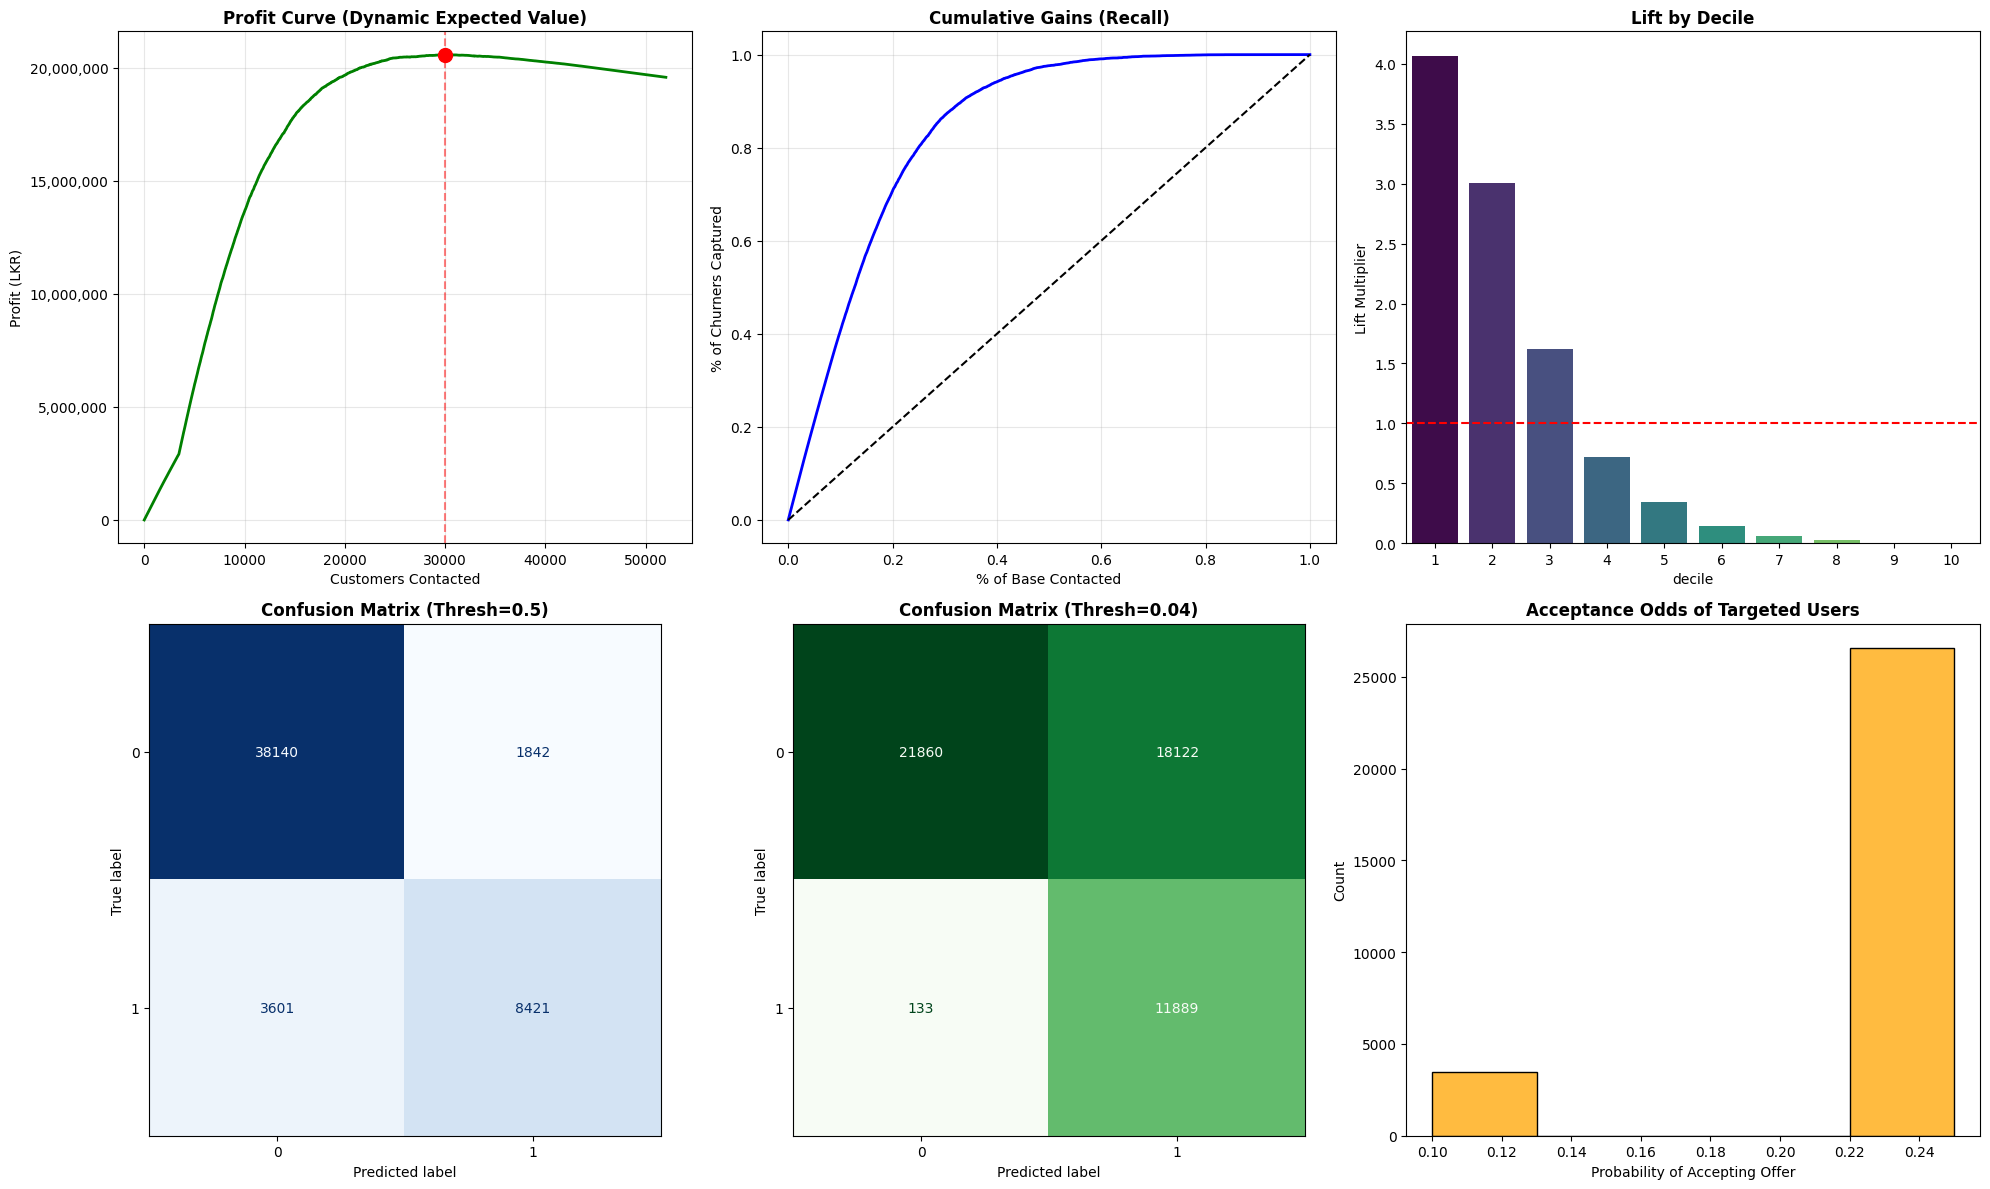

In [161]:
# Note: Inputs are defined in LKR
# rebellious-worm-205
xgb_evaluation_df = comprehensive_churn_evaluation(
        model=final_xgb_model, 
        X=X_train, 
        y=y_train,
        model_name="XGBoost Classifier",
        run_id=run_id,
        ltv=LTV_LKR,
        cost_offer=COST_OFFER_LKR,
        cost_contact=COST_CONTACT_LKR,
        acceptance_rate_base=ACCEPTANCE_RATE,
        currency="LKR"
        )

Run ID: 995f79310895457c8992069229cd46ac

  EVALUATION REPORT: LOGISTIC REGRESSION

 STRATEGIC DECISION (Optimal Threshold: 0.0896)
---------------------------------------------------------
 Target Volume:           41,102 customers
 Coverage:                79.0% of total customer base
 Avg. Risk of Target:     47.7%
 Est. Acceptance Rate:    23.6% (weighted average)
---------------------------------------------------------

 FINANCIAL IMPACT (LKR)
---------------------------------------------------------
 Total Revenue Saved:     LKR 22,186,800
 Total Campaign Spend:    LKR 2,306,470
 NET PROFIT:              LKR 19,880,330
 ROI:                     861.9%
---------------------------------------------------------

 EFFICIENCY & WASTE ANALYSIS
---------------------------------------------------------
 Correctly Targeted:      11,863 (Churners)
 Incorrectly Targeted:    29,239 (Loyalists)
 Cost of False Positives: LKR 1,716,211 (Cannibalization/Waste)
 Spend Efficiency:        For ever

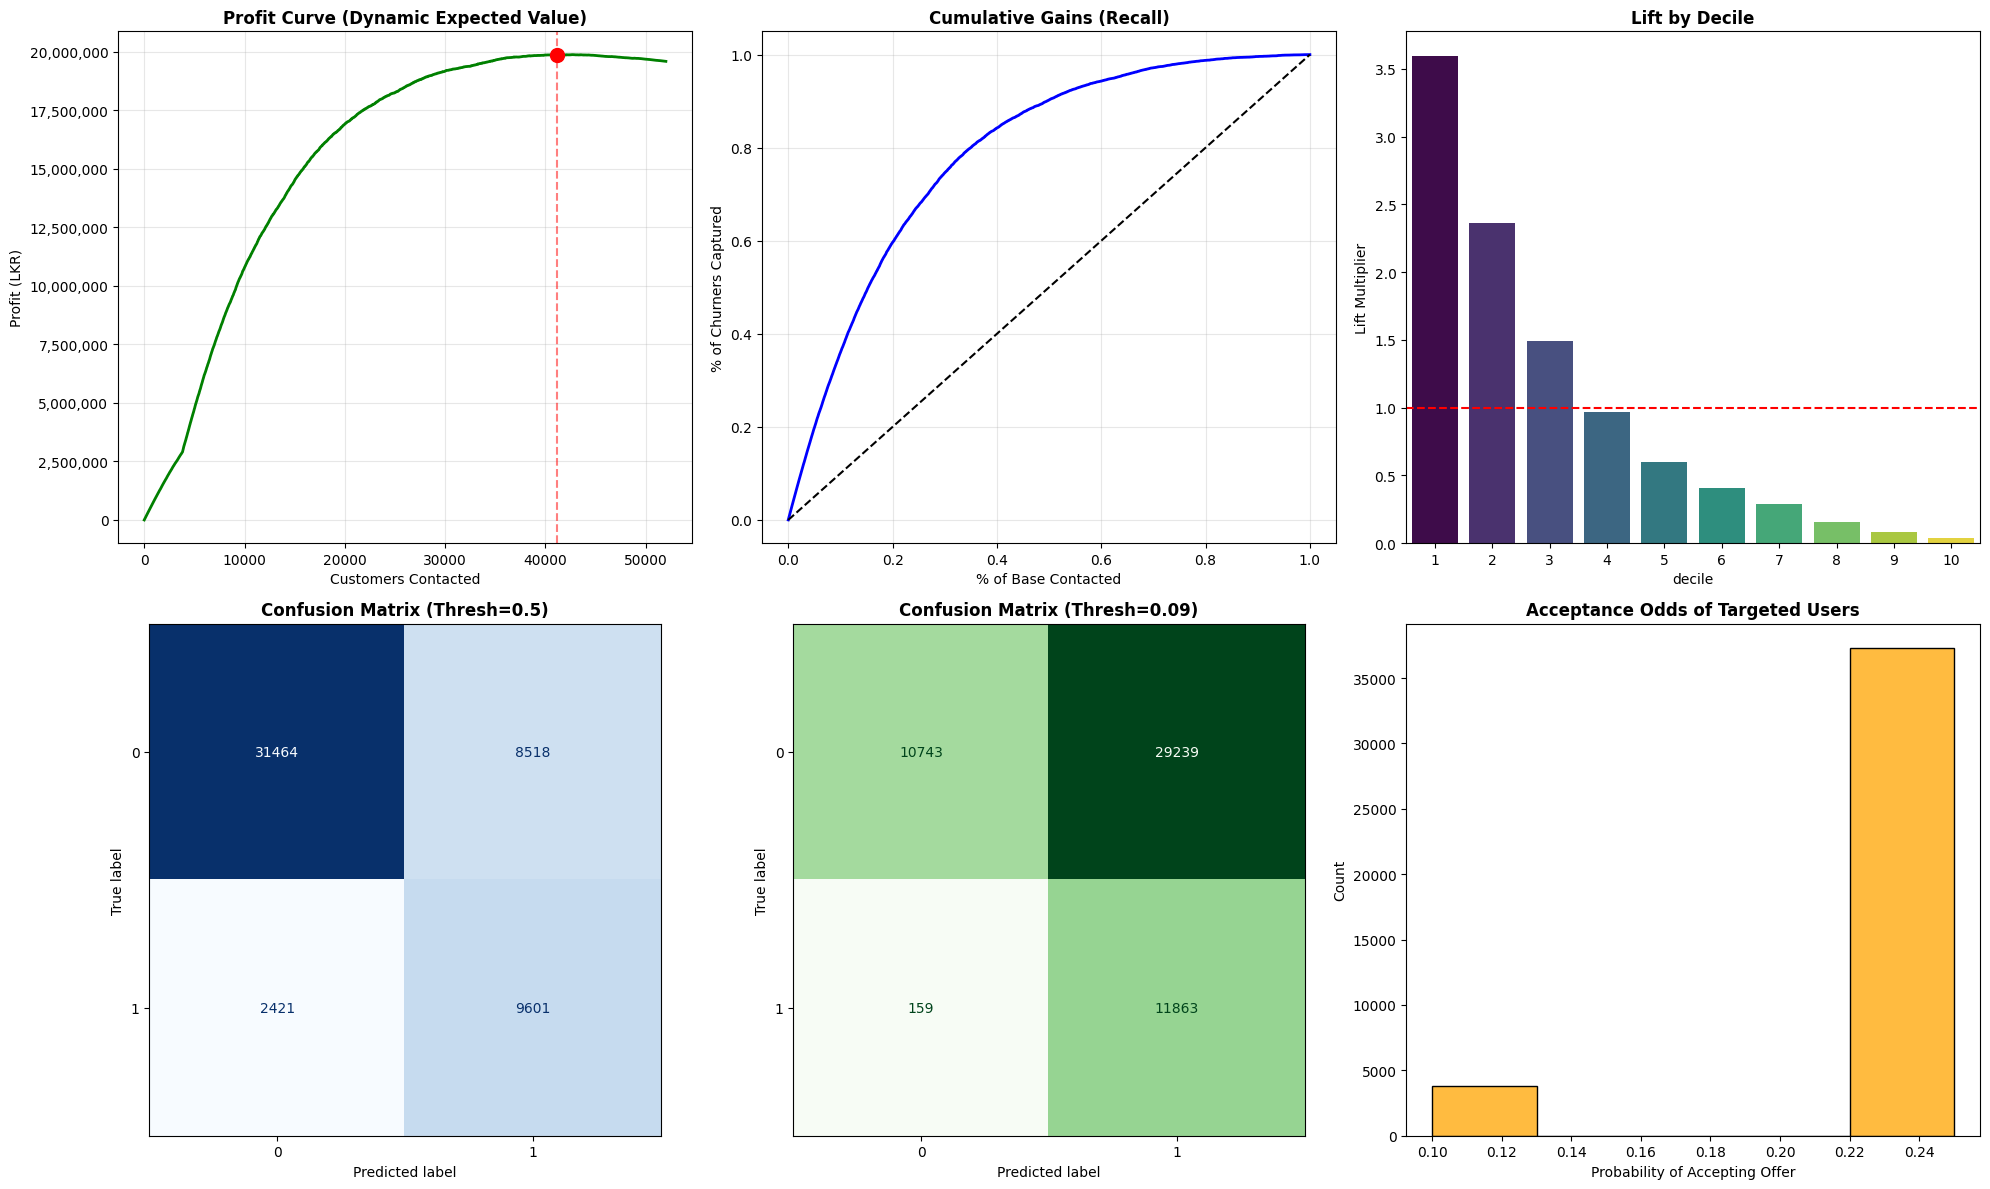

In [157]:
# Note: Inputs are defined in LKR
# classy-shrimp-733
lr_evaluation_df = comprehensive_churn_evaluation(
        model=final_lr_model,                           
        X=X_train, 
        y=y_train,
        model_name="Logistic Regression",
        run_id=run_id,
        ltv=LTV_LKR,
        cost_offer=COST_OFFER_LKR,
        cost_contact=COST_CONTACT_LKR,
        acceptance_rate_base=ACCEPTANCE_RATE,
        currency="LKR"
        )

Run ID: 04c7b7b6a6e1465ba9d7937eb4a18df9

  EVALUATION REPORT: LOGISTIC REGRESSION

 STRATEGIC DECISION (Optimal Threshold: 0.0805)
---------------------------------------------------------
 Target Volume:           41,763 customers
 Coverage:                80.3% of total customer base
 Avg. Risk of Target:     47.1%
 Est. Acceptance Rate:    23.6% (weighted average)
---------------------------------------------------------

 FINANCIAL IMPACT (LKR)
---------------------------------------------------------
 Total Revenue Saved:     LKR 22,078,800
 Total Campaign Spend:    LKR 2,341,078
 NET PROFIT:              LKR 19,737,722
 ROI:                     843.1%
---------------------------------------------------------

 EFFICIENCY & WASTE ANALYSIS
---------------------------------------------------------
 Correctly Targeted:      11,881 (Churners)
 Incorrectly Targeted:    29,882 (Loyalists)
 Cost of False Positives: LKR 1,753,465 (Cannibalization/Waste)
 Spend Efficiency:        For ever

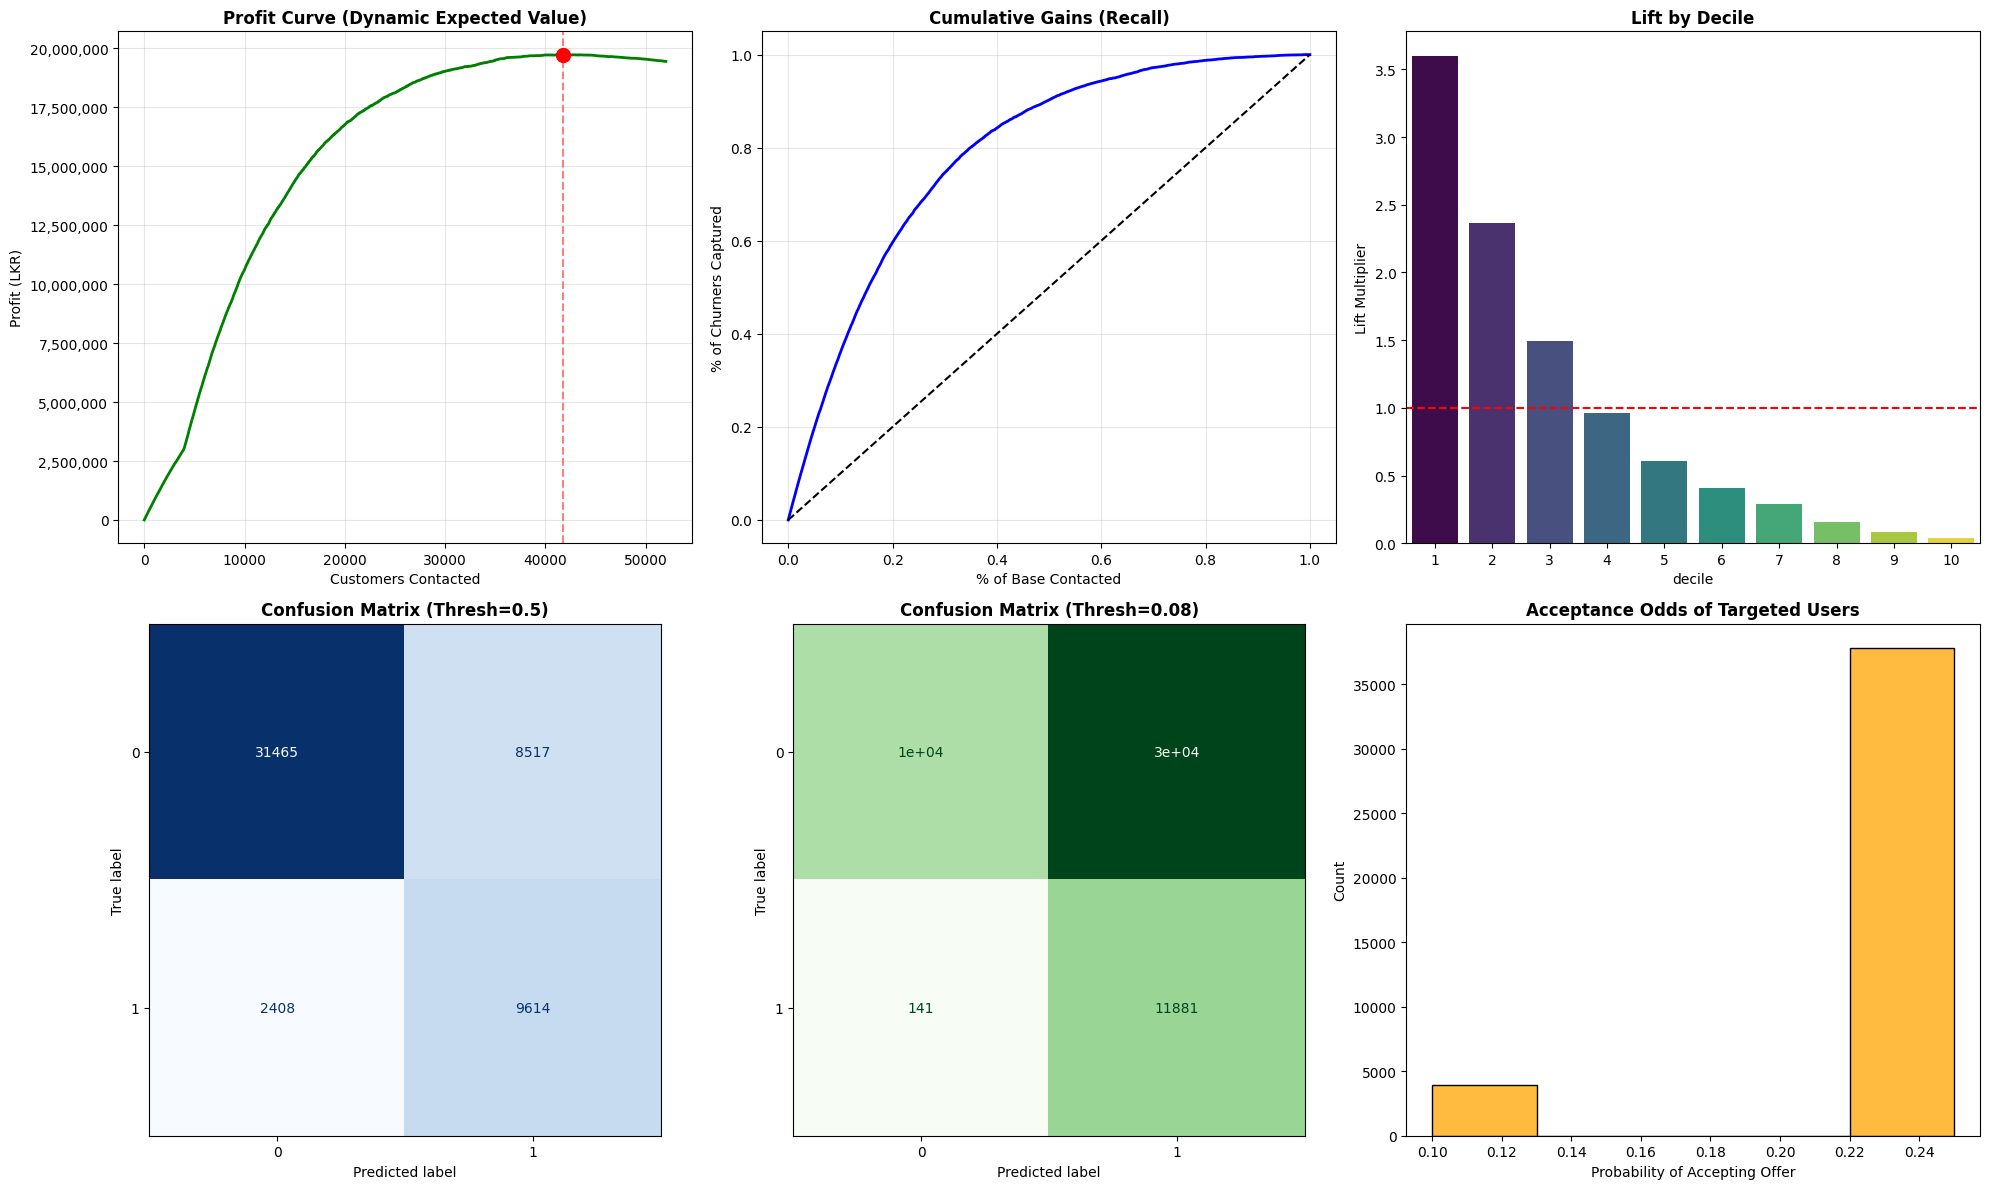

In [127]:
# Note: Inputs are defined in LKR
# casual-boar-724
lr_evaluation_df = comprehensive_churn_evaluation(
        model=final_lr_model,                           
        X=X_train, 
        y=y_train,
        model_name="Logistic Regression",
        run_id=run_id,
        ltv=LTV_LKR,
        cost_offer=COST_OFFER_LKR,
        cost_contact=COST_CONTACT_LKR,
        acceptance_rate_base=ACCEPTANCE_RATE,
        currency="LKR"
        )

Run ID: 4fc29441fd38403983fcc0271d947df1

  EVALUATION REPORT: XGBOOST CLASSIFIER

 STRATEGIC DECISION (Optimal Threshold: 0.0294)
---------------------------------------------------------
 Target Volume:           33,377 customers
 Coverage:                64.2% of total customer base
 Avg. Risk of Target:     35.5%
 Est. Acceptance Rate:    23.5% (weighted average)
---------------------------------------------------------

 FINANCIAL IMPACT (LKR)
---------------------------------------------------------
 Total Revenue Saved:     LKR 22,339,800
 Total Campaign Spend:    LKR 1,862,365
 NET PROFIT:              LKR 20,477,435
 ROI:                     1099.5%
---------------------------------------------------------

 EFFICIENCY & WASTE ANALYSIS
---------------------------------------------------------
 Correctly Targeted:      11,898 (Churners)
 Incorrectly Targeted:    21,479 (Loyalists)
 Cost of False Positives: LKR 1,268,176 (Cannibalization/Waste)
 Spend Efficiency:        For ever

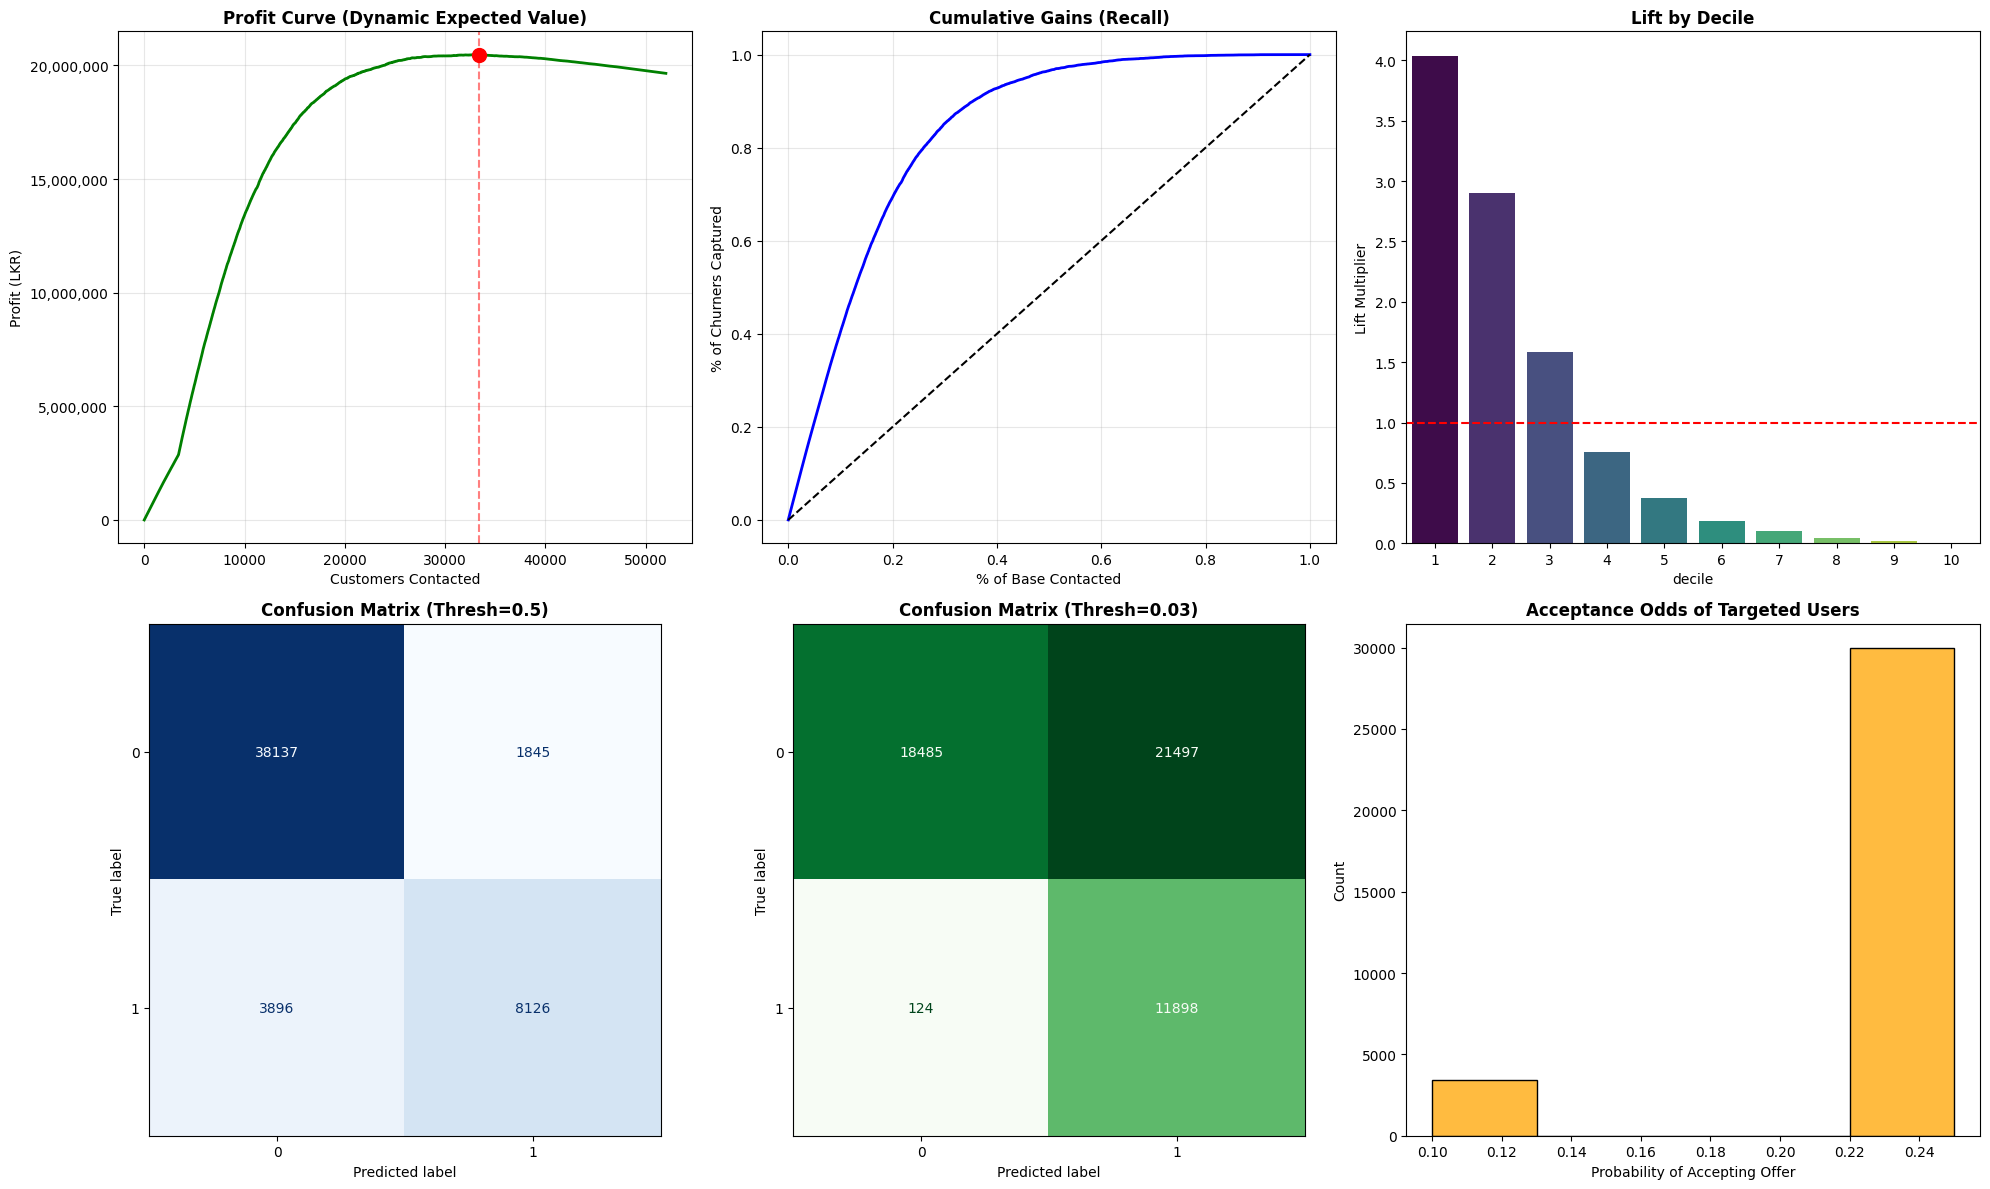

In [78]:
# Note: Inputs are defined in LKR
# dapper-sheep-389
xgb_evaluation_df = comprehensive_churn_evaluation(
        model=final_xgb_model, 
        X=X_train, 
        y=y_train,
        model_name="XGBoost Classifier",
        run_id=run_id,
        ltv=LTV_LKR,
        cost_offer=COST_OFFER_LKR,
        cost_contact=COST_CONTACT_LKR,
        acceptance_rate_base=ACCEPTANCE_RATE,
        currency="LKR"
        )

Run ID: 5ad9158ccd444fd8b0893f021d6f3fe5

  EVALUATION REPORT: LOGISTIC REGRESSION

 STRATEGIC DECISION (Optimal Threshold: 0.0805)
---------------------------------------------------------
 Target Volume:           41,763 customers
 Coverage:                80.3% of total customer base
 Avg. Risk of Target:     47.1%
 Est. Acceptance Rate:    23.6% (weighted average)
---------------------------------------------------------

 FINANCIAL IMPACT (LKR)
---------------------------------------------------------
 Total Revenue Saved:     LKR 22,078,800
 Total Campaign Spend:    LKR 2,341,078
 NET PROFIT:              LKR 19,737,722
 ROI:                     843.1%
---------------------------------------------------------

 EFFICIENCY & WASTE ANALYSIS
---------------------------------------------------------
 Correctly Targeted:      11,881 (Churners)
 Incorrectly Targeted:    29,882 (Loyalists)
 Cost of False Positives: LKR 1,753,465 (Cannibalization/Waste)
 Spend Efficiency:        For ever

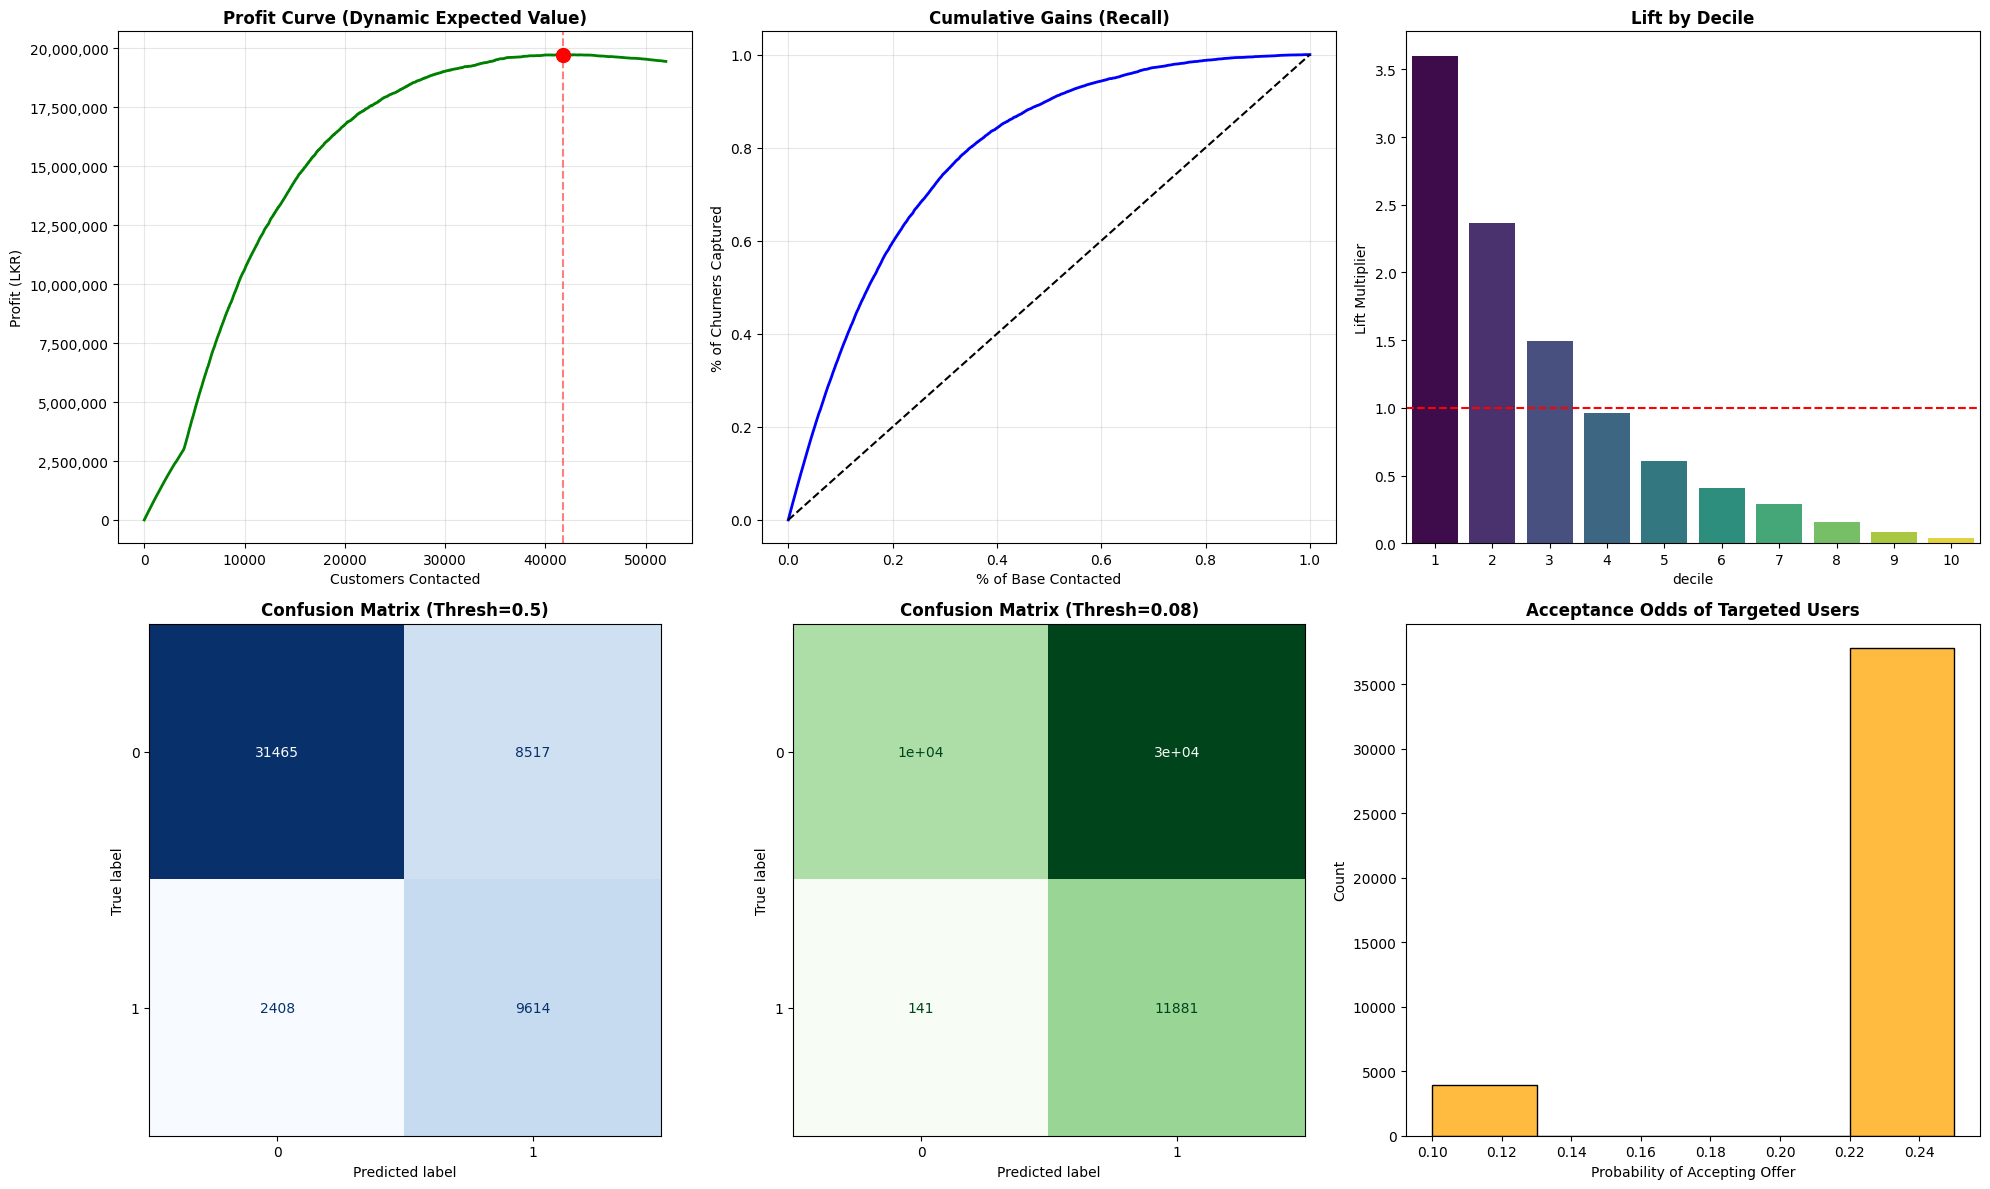

In [124]:
# Note: Inputs are defined in LKR
# beautiful-yak-143
lr_evaluation_df = comprehensive_churn_evaluation(
        model=final_lr_model,                           
        X=X_train, 
        y=y_train,
        model_name="Logistic Regression",
        run_id=run_id,
        ltv=LTV_LKR,
        cost_offer=COST_OFFER_LKR,
        cost_contact=COST_CONTACT_LKR,
        acceptance_rate_base=ACCEPTANCE_RATE,
        currency="LKR"
        )

***Insights:***

* The model struggles to identify churners who have stable spending volatility (spend_volatility_shift near 0) but sudden drops in Week 4 data. We may need a specific feature for 'Sudden Week 4 Drop' in version 2.0.

# 3.7 Final Evaluation

In [68]:
# Load the dataset for testing
test_df = pd.read_parquet("../data/processed/test_df.parquet", engine="fastparquet")

# Define Selected Features
selected_features=['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1',
                   'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week',
                   'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1',
                   'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1',
                   'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score',
                   'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2',
                   'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']

X_test = test_df[selected_features]
y_test = test_df['churn']
del test_df
gc.collect()
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Testing data shape: (13001, 23), Testing labels shape: (13001,)


## 3.7.1 Business Evaluation

The XGBoost model is prefered. It generates 3.5% higher Net Profit and delivers a massive 43% improvement in ROI compared to the baseline Logistic Regression.

Crucially, XGBoost is more efficient: it achieves these results by targeting 11,000 fewer customers, which saves us operational effort and protects our brand from spamming loyal customers with unnecessary retention offers.

Run ID: 21c6630d6a2442398ebd694f6d616622

  EVALUATION REPORT: XGBOOST CLASSIFIER

 STRATEGIC DECISION (Optimal Threshold: 0.0201)
---------------------------------------------------------
 Target Volume:           9,151 customers
 Coverage:                70.4% of total customer base
 Avg. Risk of Target:     32.6%
 Est. Acceptance Rate:    23.6% (weighted average)
---------------------------------------------------------

 FINANCIAL IMPACT (LKR)
---------------------------------------------------------
 Total Revenue Saved:     LKR 5,553,450
 Total Campaign Spend:    LKR 513,408
 NET PROFIT:              LKR 5,040,042
 ROI:                     981.7%
---------------------------------------------------------

 EFFICIENCY & WASTE ANALYSIS
---------------------------------------------------------
 Correctly Targeted:      2,956 (Churners)
 Incorrectly Targeted:    6,195 (Loyalists)
 Cost of False Positives: LKR 365,704 (Cannibalization/Waste)
 Spend Efficiency:        For every LKR 1 sp

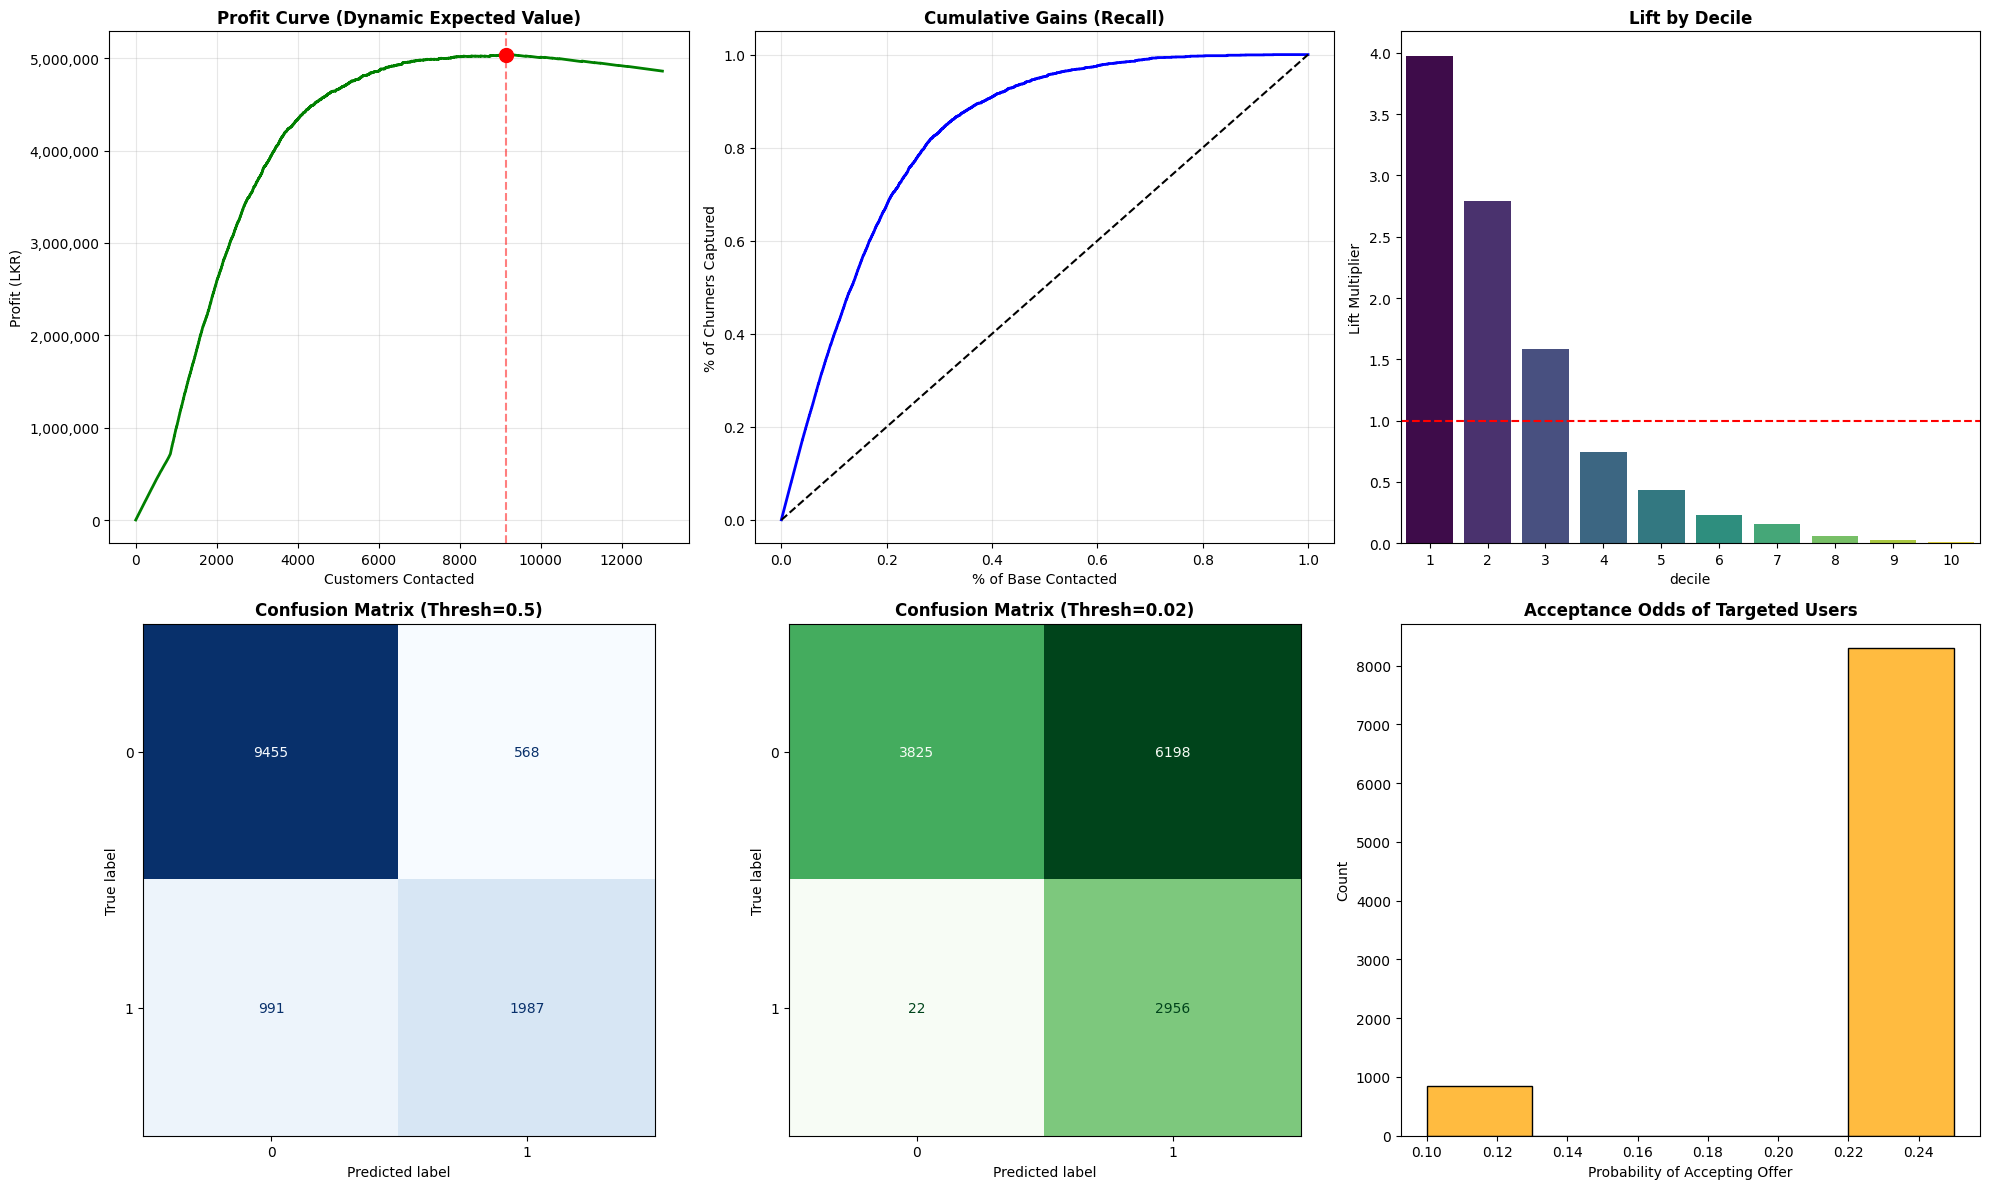

In [168]:
# Note: Inputs are defined in LKR
# rebellious-worm-205
xgb_evaluation_df = comprehensive_churn_evaluation(
        model=final_xgb_model, 
        X=X_test, 
        y=y_test,
        model_name="XGBoost Classifier",
        run_id=run_id,
        ltv=LTV_LKR,
        cost_offer=COST_OFFER_LKR,
        cost_contact=COST_CONTACT_LKR,
        acceptance_rate_base=ACCEPTANCE_RATE,
        currency="LKR"
        )

## 3.7.2 Sensitivity Analysis

Running Sensitivity Analysis on Campaign Acceptance Rates...
Pre-computing model probabilities...
Running analysis on 3 scenarios...

 SENSITIVITY ANALYSIS: STRATEGY COMPARISON (LKR)
                              Scenario Base Acceptance Offer Cost  Max Profit  Optimal Volume         ROI
         Bronze (20% Off) - 18% Uptake           18.0%        150  3479236.80            9304 1334.599486
Gold (30% Off) - 25% Uptake (Baseline)           25.0%        225  4683788.25            9151  929.670308
       Platinum (50% Off) - 35% Uptake           35.0%        375  6156707.25            7943  630.304666



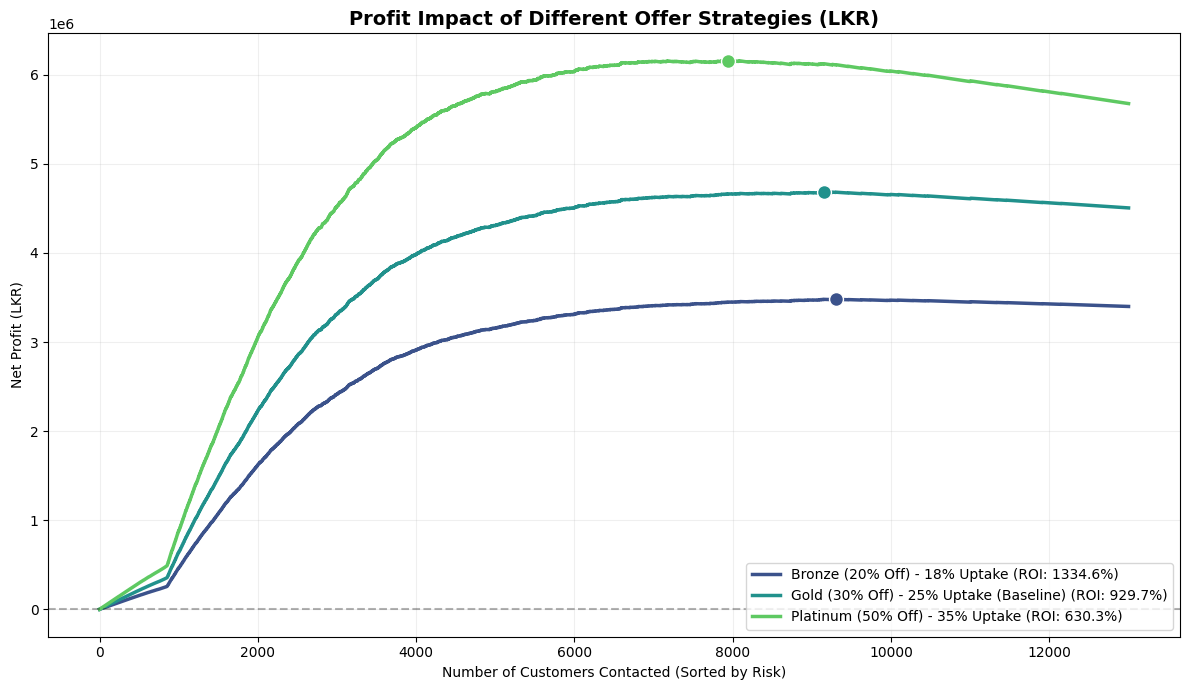

In [169]:
# Sensitivity Analysis
# Define scenarios with specific Costs and Acceptance Rates
scenarios = [
    # SCENARIO A: The "Bronze" Offer (20% Off)
    # Cheaper (Rs. 150) but low acceptance (18%)
    {'rate': 0.18, 'cost': 150, 'label': 'Bronze (20% Off) - 18% Uptake'},
    
    # SCENARIO B: The "Gold" Offer (30% Off) - THE CHOSEN STRATEGY
    # Balanced Cost (Rs. 225) and good acceptance (25%)
    {'rate': 0.25, 'cost': 225, 'label': 'Gold (30% Off) - 25% Uptake (Baseline)'},
    
    # SCENARIO C: The "Platinum" Offer (50% Off)
    # Expensive (Rs. 375) but high acceptance (35%)
    {'rate': 0.35, 'cost': 375, 'label': 'Platinum (50% Off) - 35% Uptake'}
]
print("Running Sensitivity Analysis on Campaign Acceptance Rates...")
run_sensitivity_analysis(final_xgb_model, X_test, y_test, scenarios=scenarios,
                         ltv=LTV_LKR, cost_contact=COST_CONTACT_LKR, currency="LKR",
                         high_risk_threshold=0.9, high_risk_decay=0.2)

## 3.7.3 Error Analysis

--- ERROR ANALYSIS REPORT (Threshold: 0.0201) ---


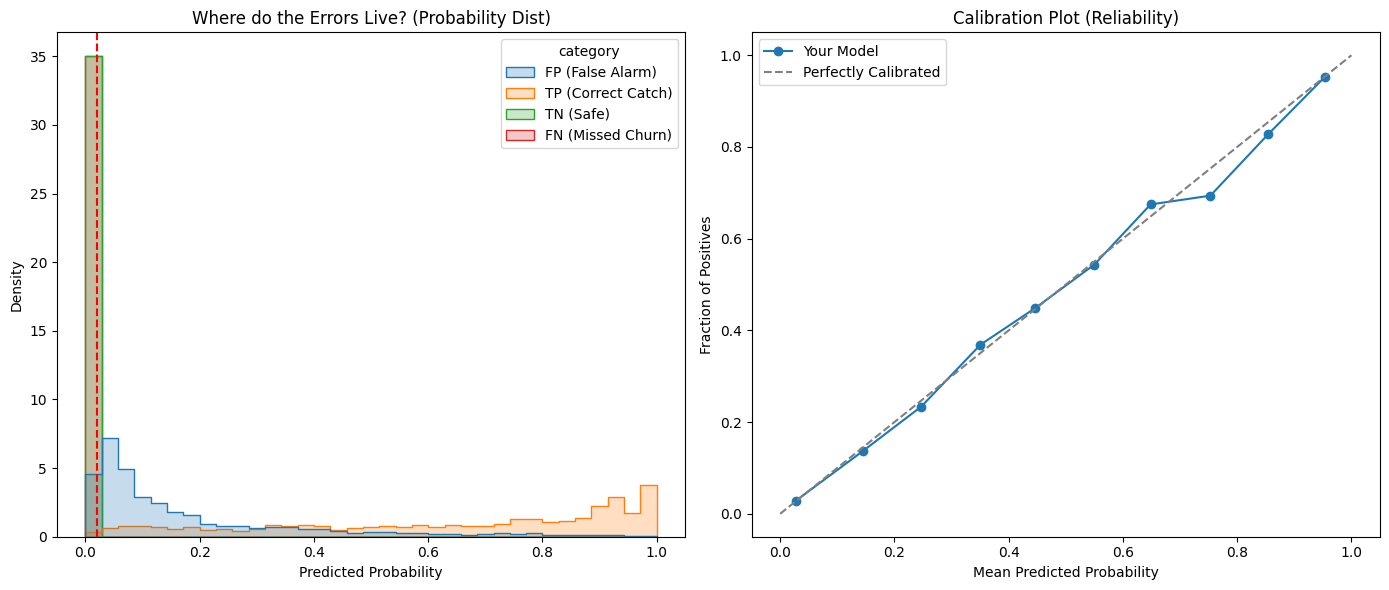


>>> PROFILING THE MISTAKES
Compare the average feature values of Errors vs. Correct predictions.

--- FALSE POSITIVE ANALYSIS (Loyalists we scared) ---
Why did the model think they would churn?
- trend_spend_w4_vs_w1: FP Avg (-0.37) is +372.8% vs Loyal Avg (-0.08)
- trend_spend_w2_vs_w1: FP Avg (-0.04) is -320.0% vs Loyal Avg (0.02)
- trend_data_w2_vs_w1: FP Avg (-0.09) is +211.1% vs Loyal Avg (-0.03)
- trend_data_w4_vs_w1: FP Avg (-0.40) is +181.5% vs Loyal Avg (-0.14)
- trend_spend_w3_vs_w1: FP Avg (-0.23) is +101.3% vs Loyal Avg (-0.12)

--- FALSE NEGATIVE ANALYSIS (Churners we missed) ---
Why did the model think they were safe?
- trend_spend_w2_vs_w1: FN Avg (0.08) is -164.1% vs Caught Churners (-0.13)
- trend_spend_w3_vs_w1: FN Avg (-0.04) is -89.1% vs Caught Churners (-0.40)
- peak_spend_week: FN Avg (2.73) is +86.1% vs Caught Churners (1.47)
- trend_spend_w4_vs_w1: FN Avg (-0.09) is -84.8% vs Caught Churners (-0.59)
- trend_data_w2_vs_w1: FN Avg (-0.04) is -76.5% vs Caught Chur

In [173]:
err_analysis_df = analyze_prediction_errors(model=final_xgb_model,
                          X=X_test, y=y_test,
                          threshold=0.0201, top_features=5)

## 3.7.4 Saving the Final Model

In [175]:
# SAVE THE FINAL XGBOOST MODEL
joblib.dump(final_xgb_model, '../models/telco_customer_churn_predictor_xgboost_v0.pkl')
print("Model saved to ../models/telco_customer_churn_predictor_xgboost_v0.pkl")

Model saved to ../models/telco_customer_churn_predictor_xgboost_v0.pkl


# **Final Modeling & Evaluation Summary: XGBoost Churn Model Performance**

## **1. Strategic & Financial Impact (Optimal Threshold)**
The model is highly profitable when optimized for business value rather than just accuracy.
* **Optimal Threshold:** `0.0201` (Aggressive targeting strategy)
* **Target Volume:** **9,151 customers** (70.4% of base)
* **Projected Net Profit:** **LKR 5,040,042**
* **ROI:** **981.7%** (For every LKR 1 spent, LKR 10.82 is generated)
* **Waste Analysis:** LKR 365,704 is "wasted" on false positives (loyalists), but this is acceptable given the high ROI.

## **2. Model Performance (Technical)**
* **AUC-ROC Score:** **0.924** (Excellent predictive power)
* **Lift:** **3.98x** (Top 10% of targeted customers are ~4x more likely to churn than average)
* **Trade-off:**
    * **Standard View (Threshold 0.5):** High Precision (0.78), Moderate Recall (0.67)"
    * **Business View (Threshold 0.02):** Low Precision (0.32), **Massive Recall (0.99)**. The strategy is to "catch everyone" because missing a churner is expensive in LKR, while contacting a loyalist is relatively cheap.

## **3. Sensitivity Analysis (Strategy Comparison)**
Comparing three offer tiers reveals a clear trade-off between Volume and Margin:
* **Platinum (50% Off):** **Highest Profit (LKR 6.1M)** but lowest ROI (630%). Best for maximizing raw revenue if budget allows.
* **Gold (30% Off):** Balanced approach (LKR 4.6M Profit, 930% ROI).
* **Bronze (20% Off):** Lowest Profit (LKR 3.4M) but **Highest ROI (1335%)**. Best for strict budget constraints.

## **4. Error Analysis (Why the model fails)**
* **False Positives (Loyalists we concerned):**
    * *Why?* They show **extreme spending drops** (e.g., `trend_spend_w4_vs_w1` dropped 372% more than average loyalists). The model interprets this drastic drop as "leaving," but for these customers, it might just be a vacation or temporary pause.
* **False Negatives (Churners we missed):**
    * *Why?* They looked "safe" because their spending **did not drop** significantly (`trend_spend` was stable). They likely churned for non-usage reasons (e.g., bad customer service, competitor offer) rather than declining engagement.

---
**Recommendation:**
* Adopt the **Platinum Strategy (50% Off)** if the primary goal is **maximizing total LKR profit** (LKR 6.1M potential).
* Adopt the **Gold Strategy (30% Off)** if we need to balance profit with marketing spend efficiency.
* Investigate the "False Negative" group: Since they don't show usage drops, consider adding **CSAT (Customer Satisfaction)** or **Competitor Price** features to catch them later.